In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity='all'

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

In [44]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

## Analyse des donnees

In [22]:
data = pd.read_csv("final_data3.csv")
data.head(10)

,DateTime,VehicleID,X,Y,Longitude,Latitude,Speed,FuelConsumption,CO2Emission,TravelTime,ActionId,ActionName,ActionParam,ActionDuration
0,74.0,veh1,0.000000,0.000000,0.000000,0.000000,0.000000,360596.694562,1.130576e+06,81.0,NaN,NaN,0.000000,0.0
1,3.0,veh1,1337.166671,519.186120,1.478127,43.564648,15.200000,814646.016924,2.554148e+06,31.0,0.0,accelerate,8.996184,11.0
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,80.0,veh1,222.431707,894.631401,1.464242,43.567843,36.566167,372145.857680,1.166786e+06,81.0,0.0,accelerate,6.371548,7.0
4,6.0,veh1,1289.429548,480.909632,1.477544,43.564296,23.000000,373060.535770,1.169648e+06,117.0,2.0,stop,0.000000,17.0
5,46.0,veh1,520.447991,781.739001,1.467957,43.566877,9.002357,650226.866452,2.038650e+06,58.0,0.0,accelerate,7.225606,16.0
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,36.0,veh1,602.828451,646.515988,1.469008,43.565673,36.822929,319918.348191,1.003037e+06,85.0,1.0,decelerate,9.364849,14.0
8,68.0,veh1,314.286388,1072.162824,1.465339,43.569456,25.481857,771743.265952,2.419647e+06,75.0,0.0,accelerate,7.932225,12.0
9,50.0,veh1,507.937816,812.776136,1.467795,43.567154,12.302357,331532.125270,1.039449e+06,101.0,1.0,decelerate,5.299163,16.0


In [29]:
# les valeurs de reference. Simulation sans requete
reference_values = data.iloc[0]
# print(reference_values["FuelConsumption"])

In [24]:
# suppression des lignes vides
final_data = data.dropna()
len(final_data)

303

In [25]:
len(final_data[data.ActionId == 2])

C:\Users\USER\AppData\Local\Temp/ipykernel_26924/1317111406.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  len(final_data[data.ActionId == 2])


45

<BarContainer object of 3 artists>

Text(0.5, 0, "Type d'action")

Text(0, 0.5, 'Fréquence')

Text(0.5, 1.0, 'Histogramme des occurrences des actions')

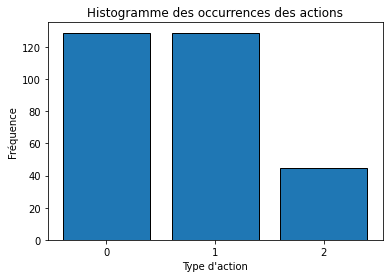

In [26]:
labels = [0,1,2]
# Comptage des occurrences de chaque label dans la colonne 'actionId'
counts = final_data['ActionId'].value_counts().reindex(labels, fill_value=0)

# Création de l'histogramme
plt.bar(counts.index, counts.values, tick_label=labels, edgecolor='black')

# Ajouter des labels et un titre
plt.xlabel("Type d'action")
plt.ylabel('Fréquence')
plt.title('Histogramme des occurrences des actions')

# Afficher l'histogramme
plt.show()

## Preparation des donnees X, y

Les donnees seront telles que si le trajet d'un scenario est superieur a celui du trajet de reference , le label du trajet sera ettiqueté a -1.
De meme si la consommation de carburant est superieur a celui du reference, le label sera -1

In [30]:
# Références pour les comparaisons
travel_reference = reference_values["TravelTime"]
fuel_reference = reference_values["FuelConsumption"]

# Ajouter la colonne y_travel
final_data['y_travel'] = final_data['TravelTime'].apply(lambda x: -1 if x > travel_reference else 1)

# Ajouter la colonne y_fuel
final_data['y_fuel'] = final_data['FuelConsumption'].apply(lambda x: -1 if x > fuel_reference else 1)


C:\Users\USER\AppData\Local\Temp/ipykernel_26924/3376312880.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_data['y_travel'] = final_data['TravelTime'].apply(lambda x: -1 if x > travel_reference else 1)
C:\Users\USER\AppData\Local\Temp/ipykernel_26924/3376312880.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_data['y_fuel'] = final_data['FuelConsumption'].apply(lambda x: -1 if x > fuel_reference else 1)


In [32]:
final_data.head(10)

,DateTime,VehicleID,X,Y,Longitude,Latitude,Speed,FuelConsumption,CO2Emission,TravelTime,ActionId,ActionName,ActionParam,ActionDuration,y_travel,y_fuel
1,3.0,veh1,1337.166671,519.186120,1.478127,43.564648,15.200000,814646.016924,2.554148e+06,31.0,0.0,accelerate,8.996184,11.0,1,-1
3,80.0,veh1,222.431707,894.631401,1.464242,43.567843,36.566167,372145.857680,1.166786e+06,81.0,0.0,accelerate,6.371548,7.0,1,-1
4,6.0,veh1,1289.429548,480.909632,1.477544,43.564296,23.000000,373060.535770,1.169648e+06,117.0,2.0,stop,0.000000,17.0,-1,-1
5,46.0,veh1,520.447991,781.739001,1.467957,43.566877,9.002357,650226.866452,2.038650e+06,58.0,0.0,accelerate,7.225606,16.0,1,-1
7,36.0,veh1,602.828451,646.515988,1.469008,43.565673,36.822929,319918.348191,1.003037e+06,85.0,1.0,decelerate,9.364849,14.0,-1,1
8,68.0,veh1,314.286388,1072.162824,1.465339,43.569456,25.481857,771743.265952,2.419647e+06,75.0,0.0,accelerate,7.932225,12.0,1,-1
9,50.0,veh1,507.937816,812.776136,1.467795,43.567154,12.302357,331532.125270,1.039449e+06,101.0,1.0,decelerate,5.299163,16.0,-1,1
11,3.0,veh1,1337.166671,519.186120,1.478127,43.564648,15.200000,372759.451806,1.168709e+06,83.0,1.0,decelerate,4.534509,10.0,-1,-1
12,33.0,veh1,701.021623,598.175773,1.470234,43.565254,50.322929,742048.058560,2.326529e+06,44.0,0.0,accelerate,7.344032,8.0,1,-1
13,55.0,veh1,440.117626,885.067935,1.466939,43.567793,25.302357,362800.610413,1.137483e+06,101.0,2.0,stop,0.000000,5.0,-1,-1


In [39]:
# len(final_data[(final_data.y_travel == -1) & (final_data.y_fuel ==-1) & (final_data.ActionId ==0)])

In [41]:
# Sélectionner X et y
X = final_data[['ActionId', 'ActionParam', 'ActionDuration', 'Longitude', 'Latitude', 'Speed']]
y = final_data[['y_travel', 'y_fuel']]

In [42]:
len(X)

303

## Apprentissage automatique

In [45]:
# Standardisation des caractéristiques
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Convertir en tensors PyTorch
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y.values, dtype=torch.float32)

In [46]:
# Séparation des données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Le modele
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(6, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 2)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x